In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prettytable as pt

### Линейная интерполяция

In [59]:
class Interpolation:

    def __init__(self):
        
        self.koefs = None
        self.poly = None

        self.readCSV("table.csv")

    def readCSV(self, fileName, i = 1):
        
        df = pd.read_csv(fileName)

        x = np.log(df['t'].to_numpy())
        y = np.log(df[f'var{i}'].to_numpy())
        
        koefs = np.zeros((y.size - 1, 2))

        for i in range(1, y.size):
            koefs[i - 1, 0] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
            koefs[i - 1, 1] = y[i - 1] - koefs[i - 1, 0] * x[i - 1]

        self.koefs = [np.mean(koefs[:, 0]), 
                      np.mean(koefs[:, 1])]

    def getResult(self, x):
        x = np.log(x)
        
        return np.exp(self.koefs[0] * x + self.koefs[1])

### Исходная система уравнений

In [60]:
class Equation:

    def __init__(self):
        self.R = 0.35
        self.Tw = 2000
        self.T0 = 1e4
        self.k0 = 8e-4
        self.p = 4
        self.c = 3e10

        self.interpolation = Interpolation()

    def T(self, z):
        return (self.Tw - self.T0) * z ** self.p + self.T0

    def u_p(self, z):
        return 3.084e-4 / (np.exp(4.799e4 / self.T(z)) - 1)

    def k(self, z):
        # return self.k0 * (self.T(z) / 300) ** 2
        return self.interpolation.getResult(self.T(z))
    
    def dU(self, z, F):
        return -3 * self.R * self.k(z) * F / self.c
    
    def dF(self, z, u, F):
        part = self.c * self.k(z) * (self.u_p(z) - u) * self.R
        
        return part / 2 if z == 0 else part - F / z

### Решение системы ОДУ

In [61]:
class Solver:

    def __init__(self, system = Equation):
        
        self.N = 100

        z0 = 0
        zMax = 1

        self.z = np.linspace(z0, zMax, self.N)

        self.step = (zMax - z0) / self.N
        self.system = system

    def psi(self, ksi):

        u, F = self.RungeKutt4(ksi)

        return 0.393 * self.system.c * u[-1] - F[-1]
    
    def DichotomyMethod(self):

        delta = 1e-4
    
        psi = np.zeros(self.N)
        ksi = np.zeros(self.N)

        ksi[1] = 1

        psi[0] = self.psi(ksi[0])
        psi[1] = self.psi(ksi[1])

        i = 1
        while np.abs((ksi[i] - ksi[i - 1]) / ksi[i]) > delta:

            ksi[i + 1] = (ksi[i] + ksi[i - 1]) / 2
            psi[i + 1] = self.psi(ksi[i + 1])

            if psi[i - 1] * psi[i + 1] < 0:
                ksi[i] = ksi[i - 1]
                psi[i] = psi[i - 1]
            elif psi[i + 1] == 0:
                i += 1
                break

            i += 1

        return ksi[i - 2 : i + 1], *self.RungeKutt4(ksi[i])

    def RungeKutt2(self, ksi):

        halfStep = self.step / 2
        
        uRes = np.zeros((self.N,))
        FRes = np.zeros((self.N,))

        uRes[0] = ksi * self.system.u_p(0)

        for i in range(1, self.N):

            z = self.z[i - 1]

            k1 = self.system.dU(z, FRes[i - 1])
            l1 = self.system.dF(z, uRes[i - 1], FRes[i - 1])

            k2 = self.system.dU(z + halfStep, FRes[i - 1] + halfStep * l1)
            l2 = self.system.dF(z + halfStep, uRes[i - 1] + halfStep * k1, FRes[i - 1] + halfStep * l1)
            
            uRes[i] =  uRes[i - 1] + self.step * k2
            FRes[i] =  FRes[i - 1] + self.step * l2

        return uRes, FRes

    def RungeKutt4(self, ksi):

        halfStep = self.step / 2

        uRes = np.zeros((self.N,))
        FRes = np.zeros((self.N,))
   
        uRes[0] = ksi * self.system.u_p(0)

        for i in range(1, self.N):

            z = self.z[i - 1]

            k1 = self.system.dU(z, FRes[i - 1])
            l1 = self.system.dF(z, uRes[i - 1], FRes[i - 1])

            k2 = self.system.dU(z + halfStep, FRes[i - 1] + halfStep * l1)
            l2 = self.system.dF(z + halfStep, uRes[i - 1] + halfStep * k1, FRes[i - 1] + halfStep * l1)

            k3 = self.system.dU(z + halfStep, FRes[i - 1] + halfStep * l2)
            l3 = self.system.dF(z + halfStep, uRes[i - 1] + halfStep * k2, FRes[i - 1] + halfStep * l2)

            k4 = self.system.dU(z + self.step, FRes[i - 1] + self.step * l3)
            l4 = self.system.dF(z + self.step, uRes[i - 1] + self.step * k3, FRes[i - 1] + self.step * l3)

            uRes[i] =  uRes[i - 1] + self.step * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            FRes[i] =  FRes[i - 1] + self.step * (l1 + 2 * l2 + 2 * l3 + l4) / 6

        return uRes, FRes

### Результаты

In [62]:
eq = Equation()
solve = Solver(eq)

ksi, u, F = solve.DichotomyMethod()

z = solve.z
k = eq.k(z)
u_p = eq.u_p(z)

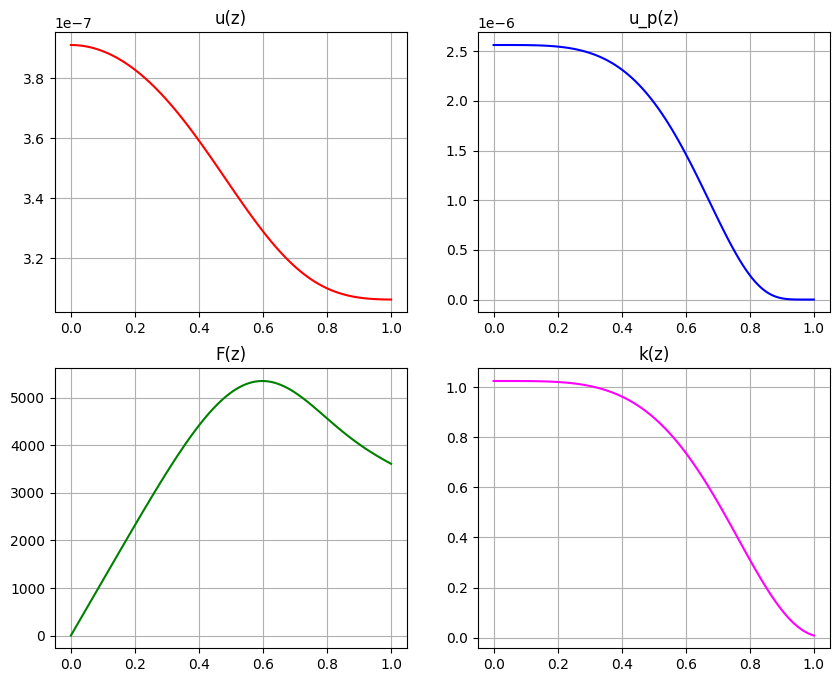

In [63]:
# Графики

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# u(z)
axs[0, 0].plot(solve.z, u, "red")
axs[0, 0].set_title("u(z)")

# u_p(z)
axs[0, 1].plot(z, u_p, "blue")
axs[0, 1].set_title("u_p(z)")

# F(z)
axs[1, 0].plot(z, F, "green")
axs[1, 0].set_title("F(z)")

# k(z)
axs[1, 1].plot(z, k, "magenta")
axs[1, 1].set_title("k(z)")

for ax in axs.flat:
    ax.grid(True)

plt.show()

In [64]:
table = pt.PrettyTable()

table.add_column("z", np.round(z, 2))
table.add_column("u(z)", np.round(u, 10))
table.add_column("u(z)", np.round(u_p, 10))
table.add_column("F(z)", np.round(F, 4))
table.add_column("k(z)", np.round(k, 4))

table.border = True

print(f"Значение ξ: {ksi[-1]:.5}")
print(f"Границы ξ: ({ksi[0]:.5}; {ksi[1]:.5})")

# print(table)

Значение ξ: 0.15266
Границы ξ: (0.15265; 0.15265)
